Our goal is to project player's end of year batting average for 2018 based on stats from March- April. We will be using various data preprocessing and supervised machine learning methods to do so. 

# Data Preprocessing

## Importing Data

First, we will read in the given batting.csv dataset and display the first few rows

In [1]:
import pandas as pd

batting = pd.read_csv('/batting.csv')
batting.head()

,playerid,Name,Team,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,MarApr_BB%,MarApr_K%,MarApr_ISO,MarApr_BABIP,MarApr_AVG,MarApr_OBP,MarApr_SLG,MarApr_LD%,MarApr_GB%,MarApr_FB%,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_AVG
0,11680,Elias Diaz,Pirates,34,31,15,2,6,6,0,0.088,0.088,0.194,0.500,0.484,0.529,0.677,0.250,0.500,0.250,0.143,0.286,0.303,0.656,0.472,0.500,0.975,0.817,0.286
1,12161,Xander Bogaerts,Red Sox,54,51,21,3,8,15,0,0.037,0.167,0.333,0.450,0.412,0.426,0.745,0.279,0.326,0.395,0.059,0.176,0.356,0.667,0.507,0.676,0.894,0.816,0.288
2,10816,Jedd Gyorko,Cardinals,30,22,8,2,5,5,1,0.200,0.200,0.318,0.400,0.364,0.500,0.682,0.235,0.235,0.529,0.111,0.222,0.295,0.596,0.408,0.522,0.821,0.686,0.262
3,13611,Mookie Betts,Red Sox,107,90,31,8,29,18,3,0.121,0.112,0.389,0.324,0.344,0.439,0.733,0.177,0.304,0.519,0.146,0.195,0.191,0.598,0.356,0.694,0.952,0.869,0.346
4,11493,Manny Machado,Orioles,125,108,39,9,14,22,2,0.136,0.128,0.315,0.361,0.361,0.448,0.676,0.163,0.359,0.478,0.205,0.205,0.289,0.711,0.458,0.654,0.891,0.801,0.297


I will now import Fangraph data on hitters' exit velocity in March and April of 2018. As a heuristic, I think exit velocity is useful in predicting batting average, so I decided to include it.

In [2]:
exitVelo = pd.read_csv('/exitVelo.csv')

exitVelo.head()

,Name,Team,G,PA,HR,R,RBI,SB,BB%,K%,ISO,BABIP,AVG,OBP,SLG,wOBA,wRC+,EV,BsR,Off,Def,WAR,playerid
0,Didi Gregorius,Yankees,28,121,10,24,30,2,14.9%,13.2%,0.408,0.289,0.327,0.421,0.735,0.463,199.0,86.5,0.6,14.9,2.1,2.2,6012
1,Mookie Betts,Red Sox,24,107,8,29,18,3,12.1%,11.2%,0.389,0.324,0.344,0.439,0.733,0.481,207.0,93.3,0.8,14.4,2.0,2.1,13611
2,Manny Machado,Orioles,28,125,9,14,22,2,13.6%,12.8%,0.315,0.361,0.361,0.448,0.676,0.464,200.0,92.1,-0.1,14.8,-0.9,1.9,11493
3,Mike Trout,Angels,28,125,10,21,18,5,16.0%,20.0%,0.340,0.290,0.291,0.408,0.631,0.432,178.0,91.9,1.2,12.9,0.9,1.8,10155
4,Aaron Judge,Yankees,28,128,7,24,18,2,19.5%,30.5%,0.267,0.446,0.317,0.453,0.584,0.436,181.0,96.3,0.4,12.7,0.6,1.8,15640


There are a variety of stats here, but the only values we are interested in are the 'EV' column and the 'playerid' column (we will need playerid to match the EV with the correct players from the previous dataframe). Thus, we will now filter out all other columns but these two. 

In [3]:
exitVelo = exitVelo[['EV','playerid']]

exitVelo.head()

,EV,playerid
0,86.5,6012
1,93.3,13611
2,92.1,11493
3,91.9,10155
4,96.3,15640


Now that we have our Exit Velocity, we will join the given batting file with the exitVelo file. We will merge the two dataframes by FanGraph's player id and must make sure to merge 'left' (using the batting dataframe), so that the initial list of hitters remains intact. By merging 'left' we ensure that the no new batters from the exitVelo dataframe are added, maintaining the original list given.

In [4]:
df = pd.DataFrame.merge(batting, exitVelo, on='playerid', how='left')

df.head()

,playerid,Name,Team,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,MarApr_BB%,MarApr_K%,MarApr_ISO,MarApr_BABIP,MarApr_AVG,MarApr_OBP,MarApr_SLG,MarApr_LD%,MarApr_GB%,MarApr_FB%,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_AVG,EV
0,11680,Elias Diaz,Pirates,34,31,15,2,6,6,0,0.088,0.088,0.194,0.500,0.484,0.529,0.677,0.250,0.500,0.250,0.143,0.286,0.303,0.656,0.472,0.500,0.975,0.817,0.286,90.6
1,12161,Xander Bogaerts,Red Sox,54,51,21,3,8,15,0,0.037,0.167,0.333,0.450,0.412,0.426,0.745,0.279,0.326,0.395,0.059,0.176,0.356,0.667,0.507,0.676,0.894,0.816,0.288,92.2
2,10816,Jedd Gyorko,Cardinals,30,22,8,2,5,5,1,0.200,0.200,0.318,0.400,0.364,0.500,0.682,0.235,0.235,0.529,0.111,0.222,0.295,0.596,0.408,0.522,0.821,0.686,0.262,90.5
3,13611,Mookie Betts,Red Sox,107,90,31,8,29,18,3,0.121,0.112,0.389,0.324,0.344,0.439,0.733,0.177,0.304,0.519,0.146,0.195,0.191,0.598,0.356,0.694,0.952,0.869,0.346,93.3
4,11493,Manny Machado,Orioles,125,108,39,9,14,22,2,0.136,0.128,0.315,0.361,0.361,0.448,0.676,0.163,0.359,0.478,0.205,0.205,0.289,0.711,0.458,0.654,0.891,0.801,0.297,92.1


We can do a quick check to ensure that every batter was given an EV, as there are no null values in the dataframe.

In [5]:
df.isnull().values.any()

False

Now that we have all the stats we need, we want to remove any of the unneccessary data. We will drop the first two columns: 'playerid' and 'name', as these would be arbitrary in predicting batting average

In [6]:
del df['playerid']
del df['Name']
df.head()

,Team,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,MarApr_BB%,MarApr_K%,MarApr_ISO,MarApr_BABIP,MarApr_AVG,MarApr_OBP,MarApr_SLG,MarApr_LD%,MarApr_GB%,MarApr_FB%,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_AVG,EV
0,Pirates,34,31,15,2,6,6,0,0.088,0.088,0.194,0.500,0.484,0.529,0.677,0.250,0.500,0.250,0.143,0.286,0.303,0.656,0.472,0.500,0.975,0.817,0.286,90.6
1,Red Sox,54,51,21,3,8,15,0,0.037,0.167,0.333,0.450,0.412,0.426,0.745,0.279,0.326,0.395,0.059,0.176,0.356,0.667,0.507,0.676,0.894,0.816,0.288,92.2
2,Cardinals,30,22,8,2,5,5,1,0.200,0.200,0.318,0.400,0.364,0.500,0.682,0.235,0.235,0.529,0.111,0.222,0.295,0.596,0.408,0.522,0.821,0.686,0.262,90.5
3,Red Sox,107,90,31,8,29,18,3,0.121,0.112,0.389,0.324,0.344,0.439,0.733,0.177,0.304,0.519,0.146,0.195,0.191,0.598,0.356,0.694,0.952,0.869,0.346,93.3
4,Orioles,125,108,39,9,14,22,2,0.136,0.128,0.315,0.361,0.361,0.448,0.676,0.163,0.359,0.478,0.205,0.205,0.289,0.711,0.458,0.654,0.891,0.801,0.297,92.1


## Removing Correlated Data

Our next step in data preparation will be to removed correlated variables. Correlated variables are data that behave in a highly-related fashion, and are therefore essentially 'double-counted' by the model. Correlated data can not only lead to a larger-than-necessary model, but can also skew logistic regression and neural nets by throwing off variable weights. 

Thus, in order to remove correlated data, we will first calculate the correlation coefficients between all of our variables and plot them in a correlation matrix.

We will use the corr method to return correlation values for all the variables. A correlation close to +/- 1 represents that the variables on each side are highly correlated. As shown, there is a diagonal of 1s where each variable intersects wiith itself and the values in the upper right triangle are perfectly mirrored across the diagonal. The corr function uses Pearson's rank-based measure of association.


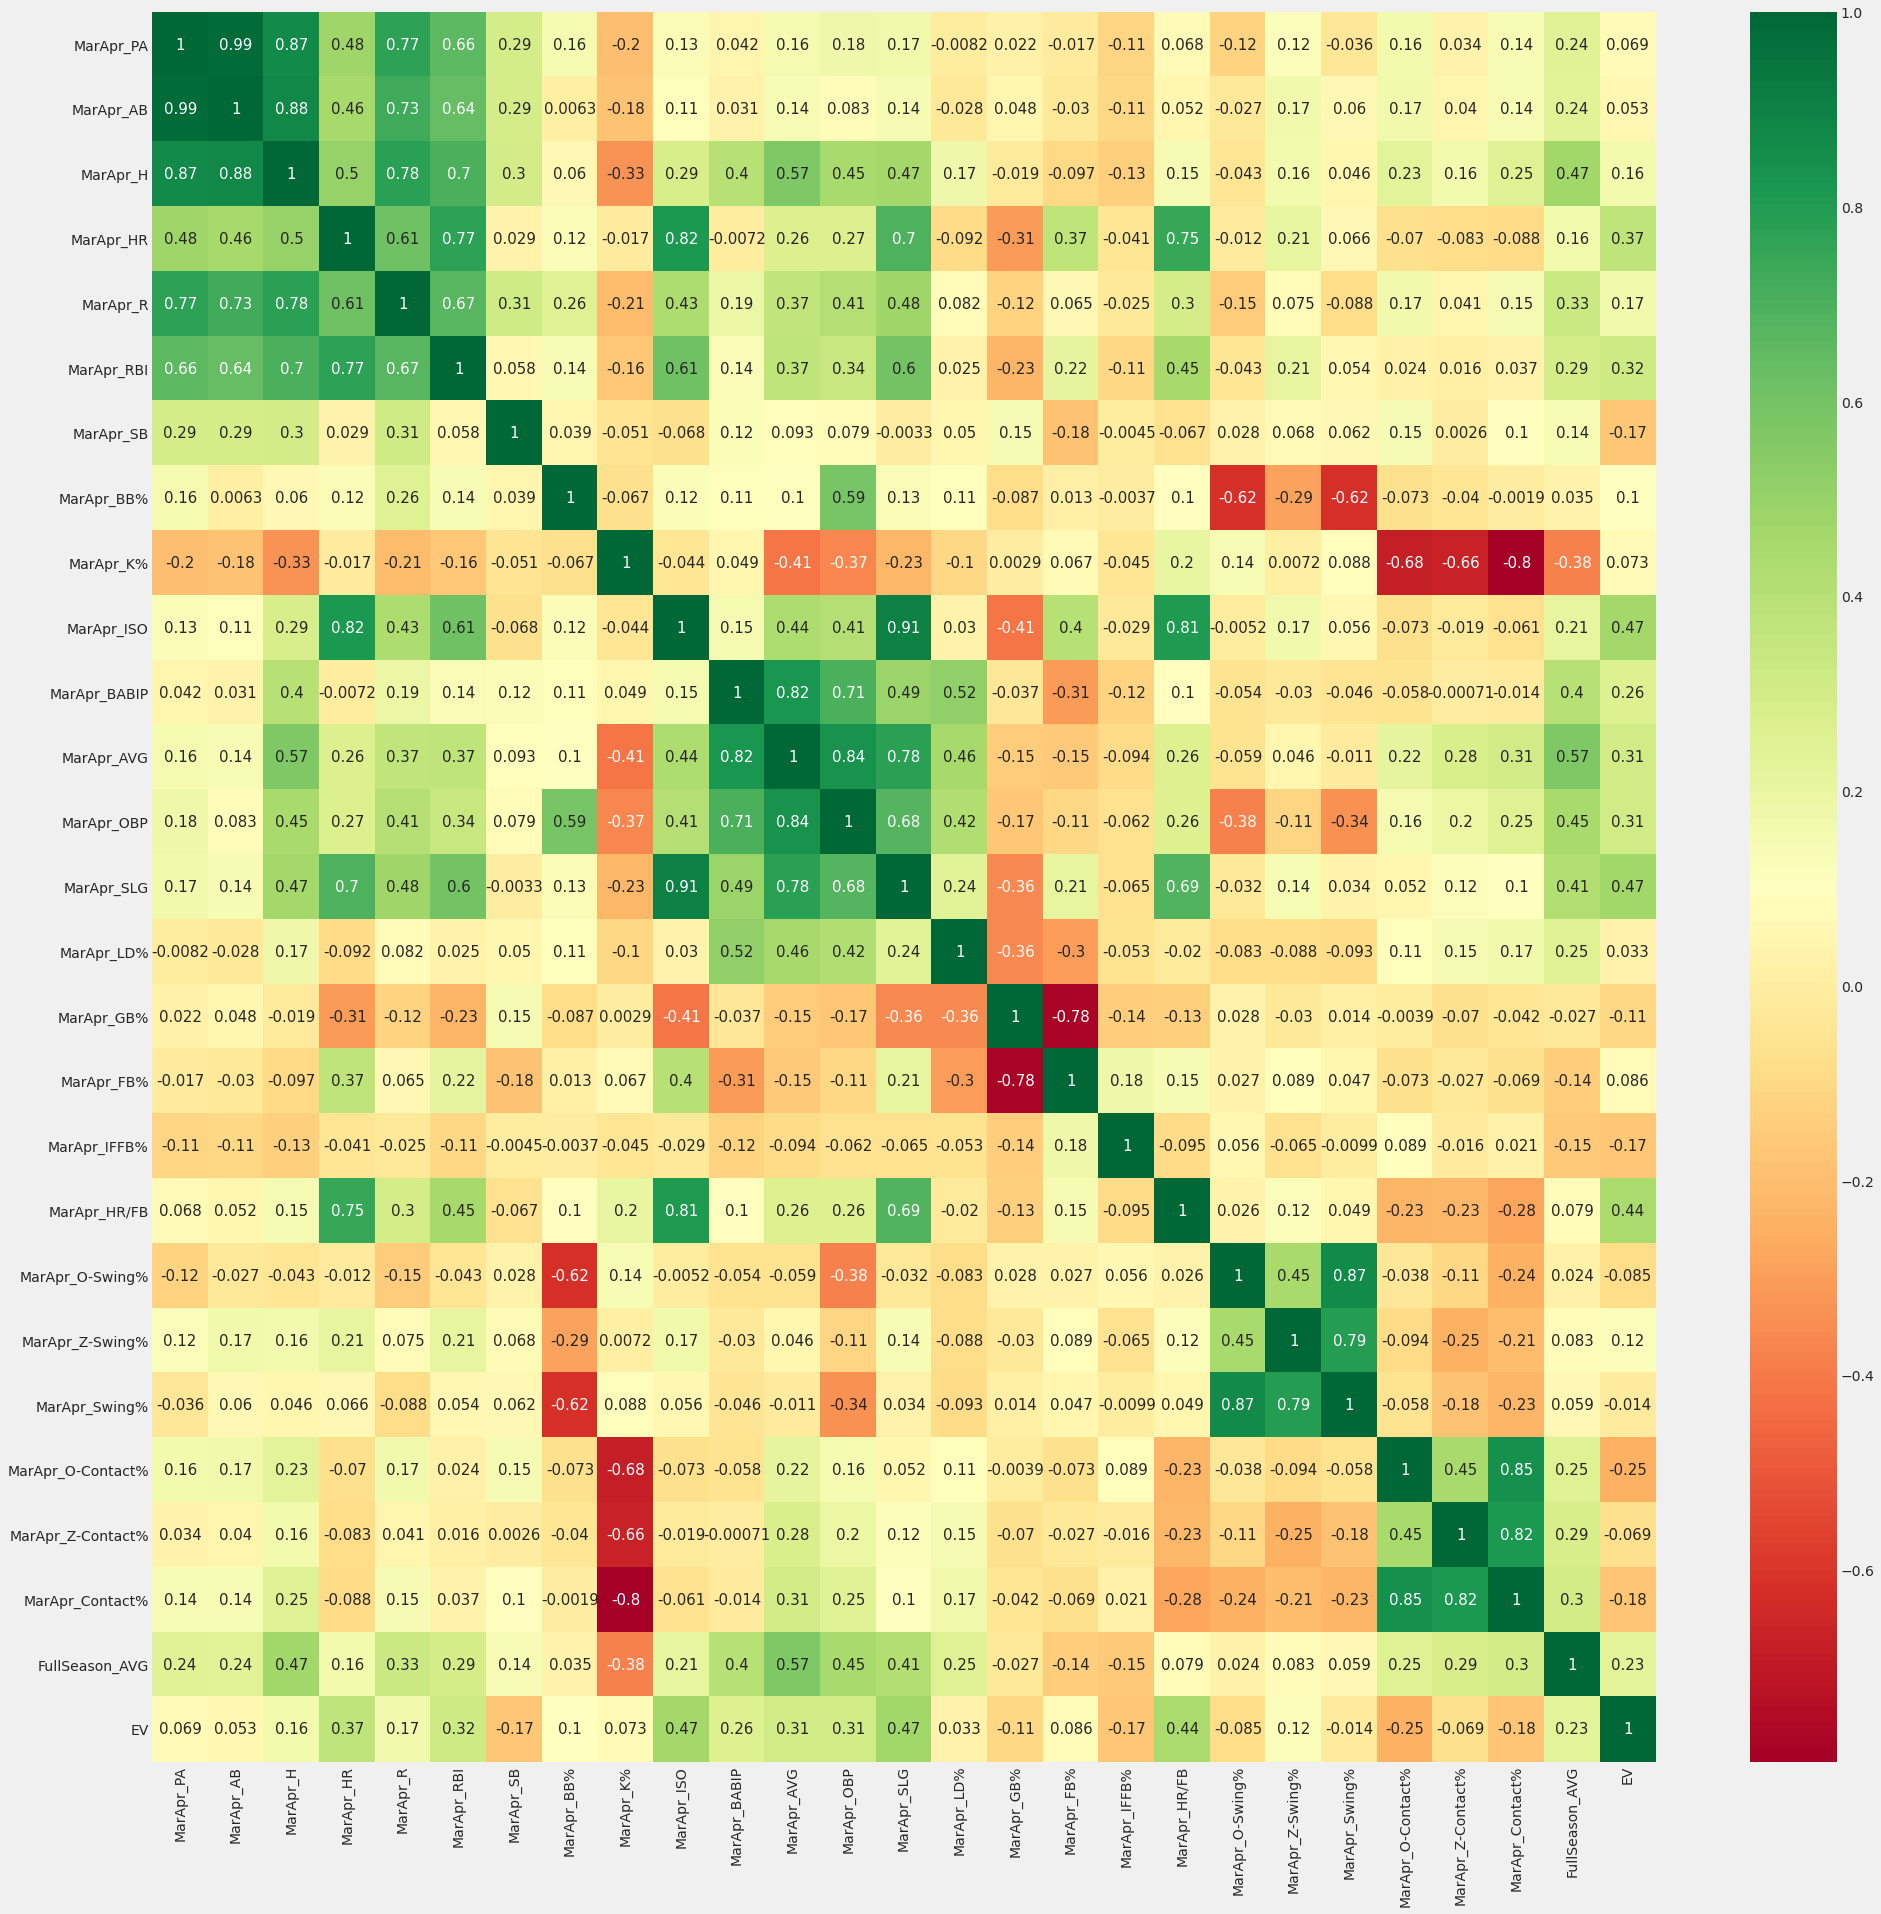

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# This will display the correlation heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(df.corr(), annot=True, cmap="RdYlGn", annot_kws={"size":15})

We can now visualize some of the correlated data (in either dark red or green), that should be removed. A correlation factor above 0.85 is considered very high, so if we have any two variables above that threshold, one of the variables will have to be removed. 

We will now cutout the upper right portion of the matrix for evaluation. With the upper right portion, we will be able to check if any correlation values are above the threshold and remove them if they are. By only isolating the top right triangle, we will be removing only one of any two variables found to be highly correlated.  

 We only need to use the upper right because, as mentioned earlier, the matrix is perfeectly reflected across the diagonal. 

In [8]:
import numpy as np

# calculates correlations and isolates one triangle
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# stores columns that have a threshold higher than 0.77 and should thus be dropped
to_drop = [column for column in upper.columns if any(upper[column] > 0.77)]
print(to_drop)  # displays which columns will be dropped due to high correlation

['MarApr_AB', 'MarApr_H', 'MarApr_R', 'MarApr_ISO', 'MarApr_AVG', 'MarApr_OBP', 'MarApr_SLG', 'MarApr_FB%', 'MarApr_HR/FB', 'MarApr_Swing%', 'MarApr_Contact%']


With the columns identified, we drop them from the dataframe

In [9]:
df = df.drop(df[to_drop], axis=1) # drops the columns found above from the dataframe
df.head()

,Team,MarApr_PA,MarApr_HR,MarApr_RBI,MarApr_SB,MarApr_BB%,MarApr_K%,MarApr_BABIP,MarApr_LD%,MarApr_GB%,MarApr_IFFB%,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,FullSeason_AVG,EV
0,Pirates,34,2,6,0,0.088,0.088,0.500,0.250,0.500,0.143,0.303,0.656,0.500,0.975,0.286,90.6
1,Red Sox,54,3,15,0,0.037,0.167,0.450,0.279,0.326,0.059,0.356,0.667,0.676,0.894,0.288,92.2
2,Cardinals,30,2,5,1,0.200,0.200,0.400,0.235,0.235,0.111,0.295,0.596,0.522,0.821,0.262,90.5
3,Red Sox,107,8,18,3,0.121,0.112,0.324,0.177,0.304,0.146,0.191,0.598,0.694,0.952,0.346,93.3
4,Orioles,125,9,22,2,0.136,0.128,0.361,0.163,0.359,0.205,0.289,0.711,0.654,0.891,0.297,92.1


## Creating 'Team' Dummy Variables

We want to keep the 'Team' variable, because, for example if someone was playing for the Astros and had an unfair advantage, that should be incorporated into our model as well. We will thus have to convert the players' team into dummy variables so that they will become numeric and fit into our final model. 

A dummy variable essentially serves as a boolean for each Categorical value (in this case different teams), so there will be a column for each team with either a 1 meaning that the batter was on that team or a 0 indicating the opposite.

In [10]:
df = pd.get_dummies(df, columns=['Team'])

df.head()

,MarApr_PA,MarApr_HR,MarApr_RBI,MarApr_SB,MarApr_BB%,MarApr_K%,MarApr_BABIP,MarApr_LD%,MarApr_GB%,MarApr_IFFB%,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,FullSeason_AVG,EV,Team_- - -,Team_Angels,Team_Astros,Team_Athletics,Team_Blue Jays,Team_Braves,Team_Brewers,Team_Cardinals,Team_Cubs,Team_Diamondbacks,Team_Dodgers,Team_Giants,Team_Indians,Team_Mariners,Team_Marlins,Team_Mets,Team_Nationals,Team_Orioles,Team_Padres,Team_Phillies,Team_Pirates,Team_Rangers,Team_Rays,Team_Red Sox,Team_Reds,Team_Rockies,Team_Royals,Team_Tigers,Team_Twins,Team_White Sox,Team_Yankees
0,34,2,6,0,0.088,0.088,0.500,0.250,0.500,0.143,0.303,0.656,0.500,0.975,0.286,90.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,54,3,15,0,0.037,0.167,0.450,0.279,0.326,0.059,0.356,0.667,0.676,0.894,0.288,92.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,30,2,5,1,0.200,0.200,0.400,0.235,0.235,0.111,0.295,0.596,0.522,0.821,0.262,90.5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,107,8,18,3,0.121,0.112,0.324,0.177,0.304,0.146,0.191,0.598,0.694,0.952,0.346,93.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,125,9,22,2,0.136,0.128,0.361,0.163,0.359,0.205,0.289,0.711,0.654,0.891,0.297,92.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Getting Variables Ready for Model

We will need to split the data into X (inputs) and y (output column) for the models we will be using. We will also split the data into train (80% of the dataset) and test (20%) to be used later. 

In [11]:
from sklearn.model_selection import train_test_split

X, y = df.drop('FullSeason_AVG', axis=1).values, df['FullSeason_AVG'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Finally, for the regression models we will be building below, we will want to have a normalized input, which means our input variables will all be scaled to be between 0 and 1. This can greatly increase model accuracy and make the regression easier for the program. We will define a MinMaxScaler to do so, which scales between 0 and 1 by default.

In [12]:
from sklearn.preprocessing import MinMaxScaler

# create scaler
scaler = MinMaxScaler()
scalery = MinMaxScaler()


scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



# Building the Models

## Regression Neural Network using Keras with Tensorflow backend

The first model is a Neural Network that is implemented with Keras, using Tensorflow backend. This model will pass the filtered inputs through a network of nodes and weighted connections, making adjustments to decrease the loss function, which is Mean Squared Error (the go-to for regression Neural Nets).

In [13]:
import tensorflow as tf
tf.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

A Neural Network is a combination of layers containing nodes, here we are defining exactly how many layers we will use and the number of nodes in each layer. We are also defining other hyperparams such as the 'elu' function, epochs (number of iterations per training step), and batch_size (number of inputs fed in at one time). We will then fit the neural net to our train data and evaluate it against our test data. See comments for more detailed explanation.

In [14]:
n_features = X_train.shape[1]
# define model of 6 layers with 256 in activation layer and one output node
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(n_features,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

# We will use this early stopping monitor to prevent overfitting
# If there are 3 iterations with no improvement to loss, the model will stop
early_stopping_monitor = EarlyStopping(monitor='loss', patience=3, mode='auto',
                                        restore_best_weights=True)

# Using Mean Square Error and Mean Absolute error as metrics for regression
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

# Fitting the model. Using a relatively small batch size due to small dataset
model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=500, batch_size=32, callbacks=[early_stopping_monitor], verbose=0)



***I had tried to implement some form of Bayesian or Random hyperparameter tuning, but wasn't able to get it working in time. I tried to just optimize hyperparameters by experimentation and estimate the best number of layers, nodes, dropout, etc.***

In [15]:
print(model.metrics_names)
# After fitting, we can evaluate against the tests
model.evaluate(x=X_test_scaled, y=y_test, batch_size=5, callbacks=None, verbose=0)

['loss', 'mse', 'mae']


[0.0010692786891013384, 0.0010692786891013384, 0.026060830801725388]

In [16]:
# custom R2-score metrics for keras backend from here: https://stackoverflow.com/questions/45250100/kerasregressor-coefficient-of-determination-r2-score
from keras import backend as K

def coeff_determination(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred, np.float32)
    y_true = tf.convert_to_tensor(y_true, np.float32)
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

y_preds = model.predict(X_test_scaled, batch_size= 10, verbose=0, callbacks=None)[:,0]
score = coeff_determination(y_test, y_preds)

print('Keras/Tensorflow Neural Net R2 score: ', score)


Keras/Tensorflow Neural Net R2 score:  tf.Tensor(-0.1335696, shape=(), dtype=float32)


The neural net provided great results in the loss, MSE, and MAE metrics for the test data, but evaluated to a best of only -0.103 R^2 score when compared to the actual batting averages.


*Using regression, we will compare models using the R^2 metric as it is designed for evaluating continuous variables such as batting average. Going to statistics as well, R2 is a direct repressentation of the correlation and fit of a regression function.*

**The R2 score of the Keras/Tensorflow Neural Network was just -0.103 at its best. I think the reason for its bad performance was the lack of hyperparameter tuning. Models like Neural Nets rely so heavily on the small hyperparameter adjustments, if I had more time I would definitely implement some form of Bayseian or Hyperband tuning.** 

## Neural Network Regression entirely in Scikit


Next, I implemented a Neural Network model using python's simple Scikit library.

In [17]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pandas as pd

This model has four layers, the first two with 64 nodes, then the next two with 32 nodes. Similar to before, early stopping is implemented, and we are using the same activation function and optimizer. While the max iteration is 500 for this model, it's expected to drop out sooner due to early_stopping that will prevent over-fitting. It is trained on the same data, but it's clear from the code that we have less control over the exact model.

Similar to the previous Neural Network, if I had an extra day, I would be really excited to implement a hyperparameter optimization for this model as well. It's known how well neural nets can perform on a task like this if given the right parameters, so it would definitely be interesting to see.

In [82]:
mlp = MLPRegressor(hidden_layer_sizes=(500,500,400,400,400),activation="relu", solver='adam', max_iter=500, random_state=1, early_stopping= True)
mlp.fit(X_train_scaled, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(500, 500, 400, 400, 400),
             learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
             max_iter=500, momentum=0.9, n_iter_no_change=10,
             nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
             solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

We will make predictions based on both the training data (to evaluate how well the model fit) and also the test data which the model has never seen before. This model does the best job of fitting the test data, reiterating the idea that a properly tuned neural net would do even better.  

In [83]:
predict_train = mlp.predict(X_train_scaled)
predict_test = mlp.predict(X_test_scaled)

In [85]:
print("R2 SCORE ON TRAIN DATA ", (r2_score(y_train, predict_train)))

R2 SCORE ON TRAIN DATA  0.2810642450049503


In [84]:
print("R2 SCORE ON TEST DATA ", (r2_score(y_test, predict_test)))

R2 SCORE ON TEST DATA  0.09452025454093449


**The best R2 score for this neural net is 0.143 (forgot to save the random state), a good score considering the difficulty of the projection.**

## Scikit Learn Linear Regression

The next model implemented was a simple linear regression, which was created using Scikit. There wasn't much to this model, but it is interesting to compare it to the neural nets. Though there wasn't a lot of code, the failure of this basic, usually reliable model, reiterates the difficulty of the assigned task.

In [22]:
from sklearn.linear_model import LinearRegression

The Linear Regresssion model is fit against the training data

In [23]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

This method allows for a quick calculation of R2 through lr.score(). The test statistics entered into the method return an R2 of -0.00627, essentially no correlation.

In [24]:
r_sq = lr.score(X_test_scaled, y_test)
print('LINEAR REG. R2 score:', r_sq)

LINEAR REG. R2 score: 0.08484939516468637


## Scikit Learn Polynomial Regression

Rather than a straight logistic regression, I also tried a polynomial regression that would theoretically be able to better fit the data.

For this model, I had to transform the training and test X-data to embody the higher degree polynomial. The transformer got the best results with a power of 4 for the regression.

In [25]:
from sklearn.preprocessing import PolynomialFeatures
transformer = PolynomialFeatures(degree=4, include_bias=False)
transformer.fit(X_train_scaled)
X_train_transformed = transformer.transform(X_train_scaled)

Once Transformed, the model is just like the linear regression and the training/r2 calculation methods are the same

In [26]:
model = LinearRegression().fit(X_train_transformed, y_train)

In [27]:
X_test_transformed = transformer.transform(X_test_scaled)

In [28]:
r_sq = model.score(X_test_transformed, y_test)
print('POLYNOMIAL REG. R2 score:', r_sq)

POLYNOMIAL REG. R2 score: -0.41480876584557147


The Polynomial Regression Model returns a final R2 of -0.415, the worst so far and surprisingly even worse than the logistic regression.

# Conclusion


**Our best R^2 value came from the implementation of Scikits neural network, which returned a value of 0.143.** This was the only significant positive correlation, and while r squared values are usually close to 1 for successful models, given the challenge of the such a projection, and the failure of other models, it's not too bad a result.

There is definitely room to continue exploring other models such as XGBoosted or RandomForestRegressors, but if I had more time, I would want to implement an optimization for the two neural network models (Tensorflow and Scikit). Scikit had a great R^2 value without even being optimized and the Tensorflow model showed promise with the low error statistics for the Mean Squared Error and Mean Absolute Error. Especially with the Tensorflow model which allows for much more control over the neural network, I think there could be significant improvements with Bayesian Optimization ([a topic I've worked with in the past](https://github.com/NaveenM12/Bayesian-Optimization-Implementations)) or something like Hyperband.

There is also definitely more work to do with parsing the data as well. If given more time, I would've liked to be more nit-picky with the inputs. Perhaps graphing each of the variables and taking the time to find issues and outliers. I could've also used the correlation matrix to not only eliminate correlated variables, but go further in identifying potenitally important connections. 

Nevertheless, the final r squared value was the best I could come up with, and the 'winning model' was undoubtedly the Neural Network.